## Credit Card Fraud Detection

### Contex

Using anomolized features and data as a reuslt of a PCA transformation (how we were given the data on kaggle https://www.kaggle.com/mlg-ulb/creditcardfraud), we have been tasked to identify and predict future fraudulent charges.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')

%matplotlib inline

In [3]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Here we can see that the dataset consists of 31 total columns including the time of the transaction, the 28 different metrics returned by the PCA transformation, the amount of the transaction and the classification (our target) - whether the transaction was fraud or not. We have no missing rows of data.

In [5]:
# defining our classes for EDA
fraud = data[data['Class'] == 1]
not_fraud = data[data['Class'] == 0]

print('There are {} fraud cases'.format(len(fraud)))
print('There are {} valid cases'.format(len(not_fraud)))
print('There are {:.2%} more valid cases than fraud cases'.format(
    (1 - len(fraud)/len(not_fraud)) 
    ))

There are 492 fraud cases
There are 284315 valid cases
There are 99.83% more valid cases than fraud cases


We can see from the number of fraud cases compared to the number of valid transactions we have highly a highly imbalanced set of data. We will have to account for this by different methods of resampling our data. We will explore not resampling first, however due to the PCA transformation the 28 PCA components are arleady scaled however the amount and time our not we will account for this too.

We can use Scikit learns Standard Scaler or Robust scaler which is more robust to outliers. First lets visualize and choose the best method to scale

Text(0.5, 1.0, 'Distribution of Transaction Time')

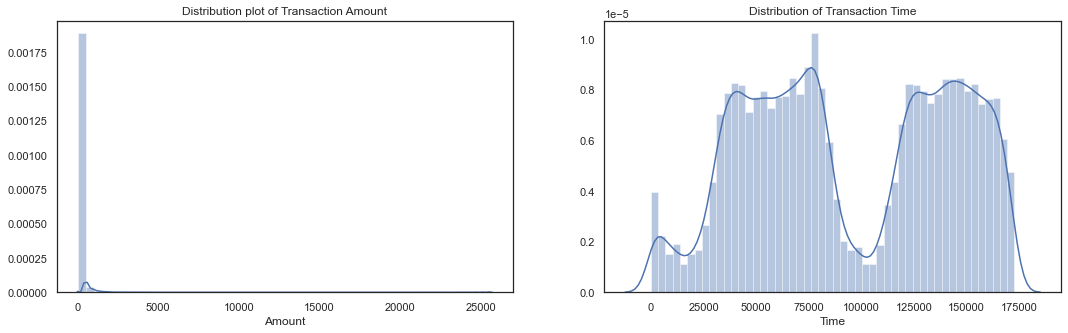

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.distplot(data.Amount, ax=ax[0])
ax[0].set_title('Distribution plot of Transaction Amount')

sns.distplot(data.Time, ax=ax[1])
ax[1].set_title('Distribution of Transaction Time')


We can see that Amount spent per transcation widely ranges with large outliers compared to the majority of transactions. We can compare the effects of different scaling options

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer

def scaling(scaler, df, int_scaling):
    clf = scaler().fit_transform(df[int_scaling].values.reshape(-1,1))
    return clf
            


(0.0, 25691.16)

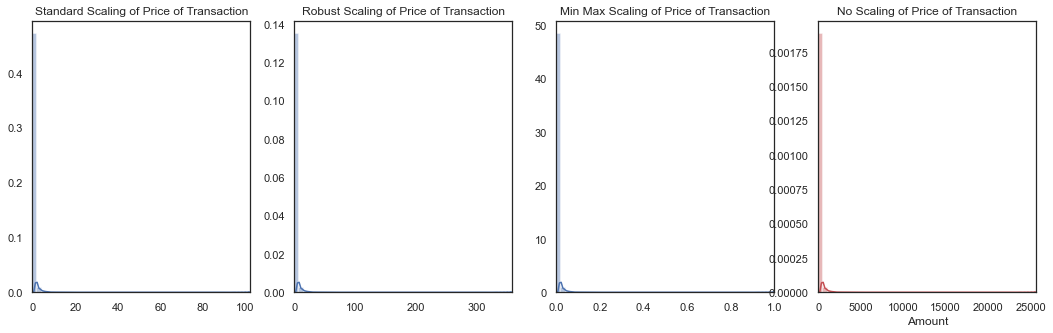

In [8]:
amount_std_scaled = scaling(StandardScaler, data, 'Amount')
amount_rob_scaled = scaling(RobustScaler, data, 'Amount')
amount_mm_scaled = scaling(MinMaxScaler, data, 'Amount')


fig, ax = plt.subplots(1, 4, figsize = (18,5))
sns.distplot(amount_std_scaled, ax = ax[0])
sns.distplot(amount_rob_scaled, ax = ax[1])
sns.distplot(amount_mm_scaled, ax = ax[2])
sns.distplot(data.Amount, ax=ax[3], color='r')

ax[0].set_title('Standard Scaling of Price of Transaction')
ax[0].set_xlim([min(amount_std_scaled), max(amount_std_scaled)])

ax[1].set_title('Robust Scaling of Price of Transaction')
ax[1].set_xlim([min(amount_rob_scaled), max(amount_rob_scaled)])

ax[2].set_title('Min Max Scaling of Price of Transaction')
ax[2].set_xlim([min(amount_mm_scaled), max(amount_mm_scaled)])

ax[3].set_title('No Scaling of Price of Transaction')
ax[3].set_xlim([min(data.Amount), max(data.Amount)])


Here we can see the diffent effects of scaling. Min Max is the most agressing by normalizing the amount between 0 and 1, while robust seams to be the most inclusive of outliers/ the larger amount. We will use the robust for scaling amount and time

In [9]:
data['scaled_amount'] =amount_rob_scaled
time_rob_scaled = scaling(RobustScaler, data, 'Time')
data['scaled_time'] = time_rob_scaled

(0.0, 172792.0)

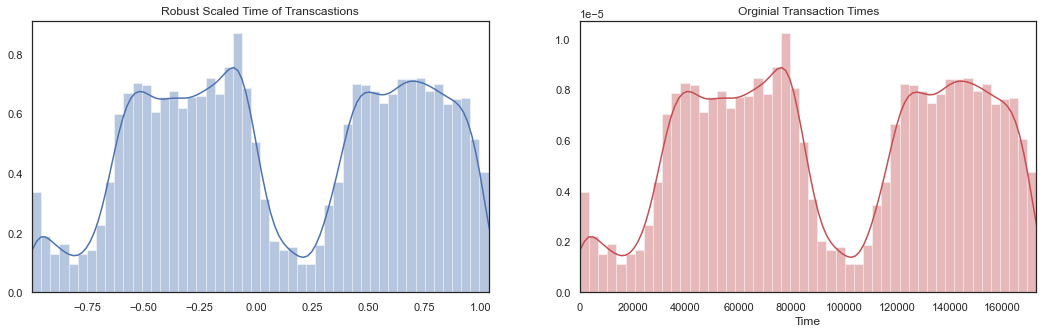

In [10]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

sns.distplot(time_rob_scaled, ax = ax[0])
sns.distplot(data.Time, ax=ax[1], color='r')

ax[0].set_title('Robust Scaled Time of Transcastions')
ax[0].set_xlim([min(time_rob_scaled), max(time_rob_scaled)])

ax[1].set_title('Orginial Transaction Times')
ax[1].set_xlim([min(data.Time), max(data.Time)])


Here we see that scaling the time data does not change the overall form however compreses the time range between -1 and 1 and adjusts the magnitude of the transactons accordingly.

In [11]:
# quick comparisson of scaled/non scaled values

data[['scaled_time','Time','scaled_amount','Amount']].head(20)

,scaled_time,Time,scaled_amount,Amount
0,-0.994983,0.0,1.783274,149.62
1,-0.994983,0.0,-0.269825,2.69
2,-0.994972,1.0,4.983721,378.66
3,-0.994972,1.0,1.418291,123.50
4,-0.994960,2.0,0.670579,69.99
5,-0.994960,2.0,-0.256131,3.67
6,-0.994937,4.0,-0.237686,4.99
7,-0.994901,7.0,0.262698,40.80
8,-0.994901,7.0,0.994900,93.20
9,-0.994878,9.0,-0.255991,3.68


### Looking at correlation between our features and classes

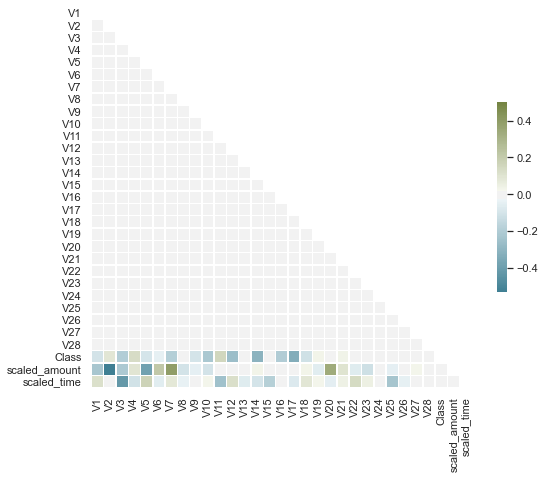

In [12]:
corr = data.drop('Time', axis=1).drop('Amount', axis=1).corr()

sns.set(style='white')
fig, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 100, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

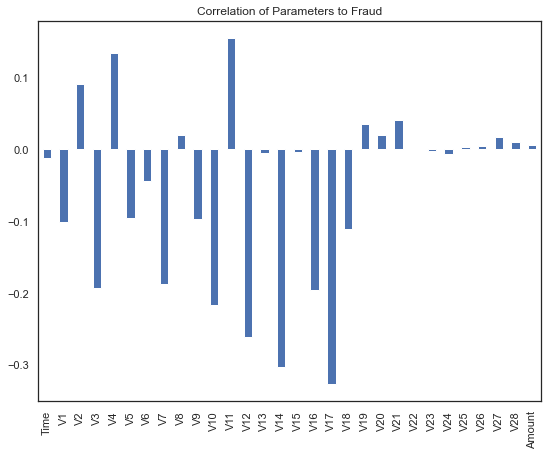

In [19]:
fig, ax = plt.subplots(figsize=(9,7))
corr_bar = data.drop('scaled_amount', axis=1).drop('scaled_time', axis=1).drop('Class', axis =1).corrwith(data.Class).plot(kind='bar', ax =ax)  #creates pairwase correlation
ax.set_title('Correlation of Parameters to Fraud')
fig.savefig('images/corr_plot.png')

From looking at the correlation matrix and also relative correlation with Class, we see some features are negatively correlated (V3, V7, V10,V14, etc..) while (V2, V4, V11) seem to be positevly correlated. We can look into that in their individual distribution plots for further insights.  

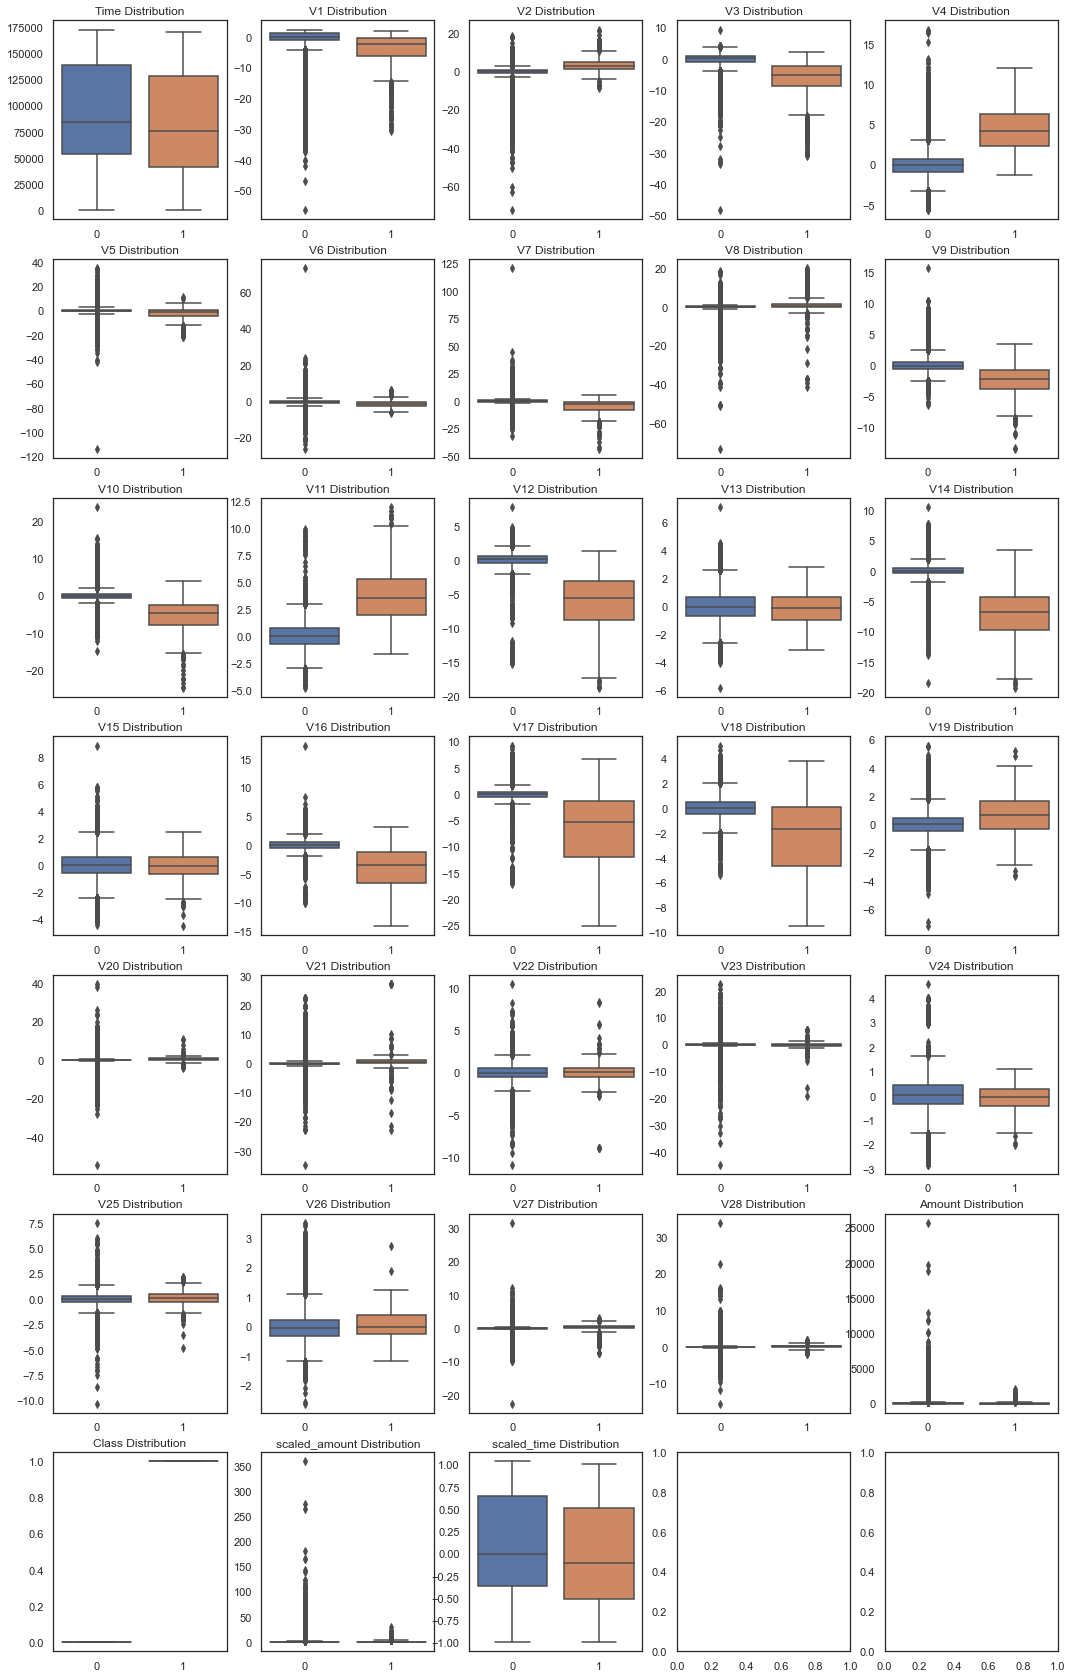

In [20]:
fig, ax = plt.subplots(7,5, figsize=(18,30))
i=0 # intilizing counter
for  ax,( i, col) in zip(ax.flat, enumerate(data.columns)):
#     print(ax, i,col)
    sns.boxplot(x= 'Class', y=col, data=data, ax=ax)
#     ax.set_xlim([min[data[col]], max[data[col]]])
    ax.set_title('{} Distribution'.format(col))
    ax.set_xlabel ('')
    ax.set_ylabel('')


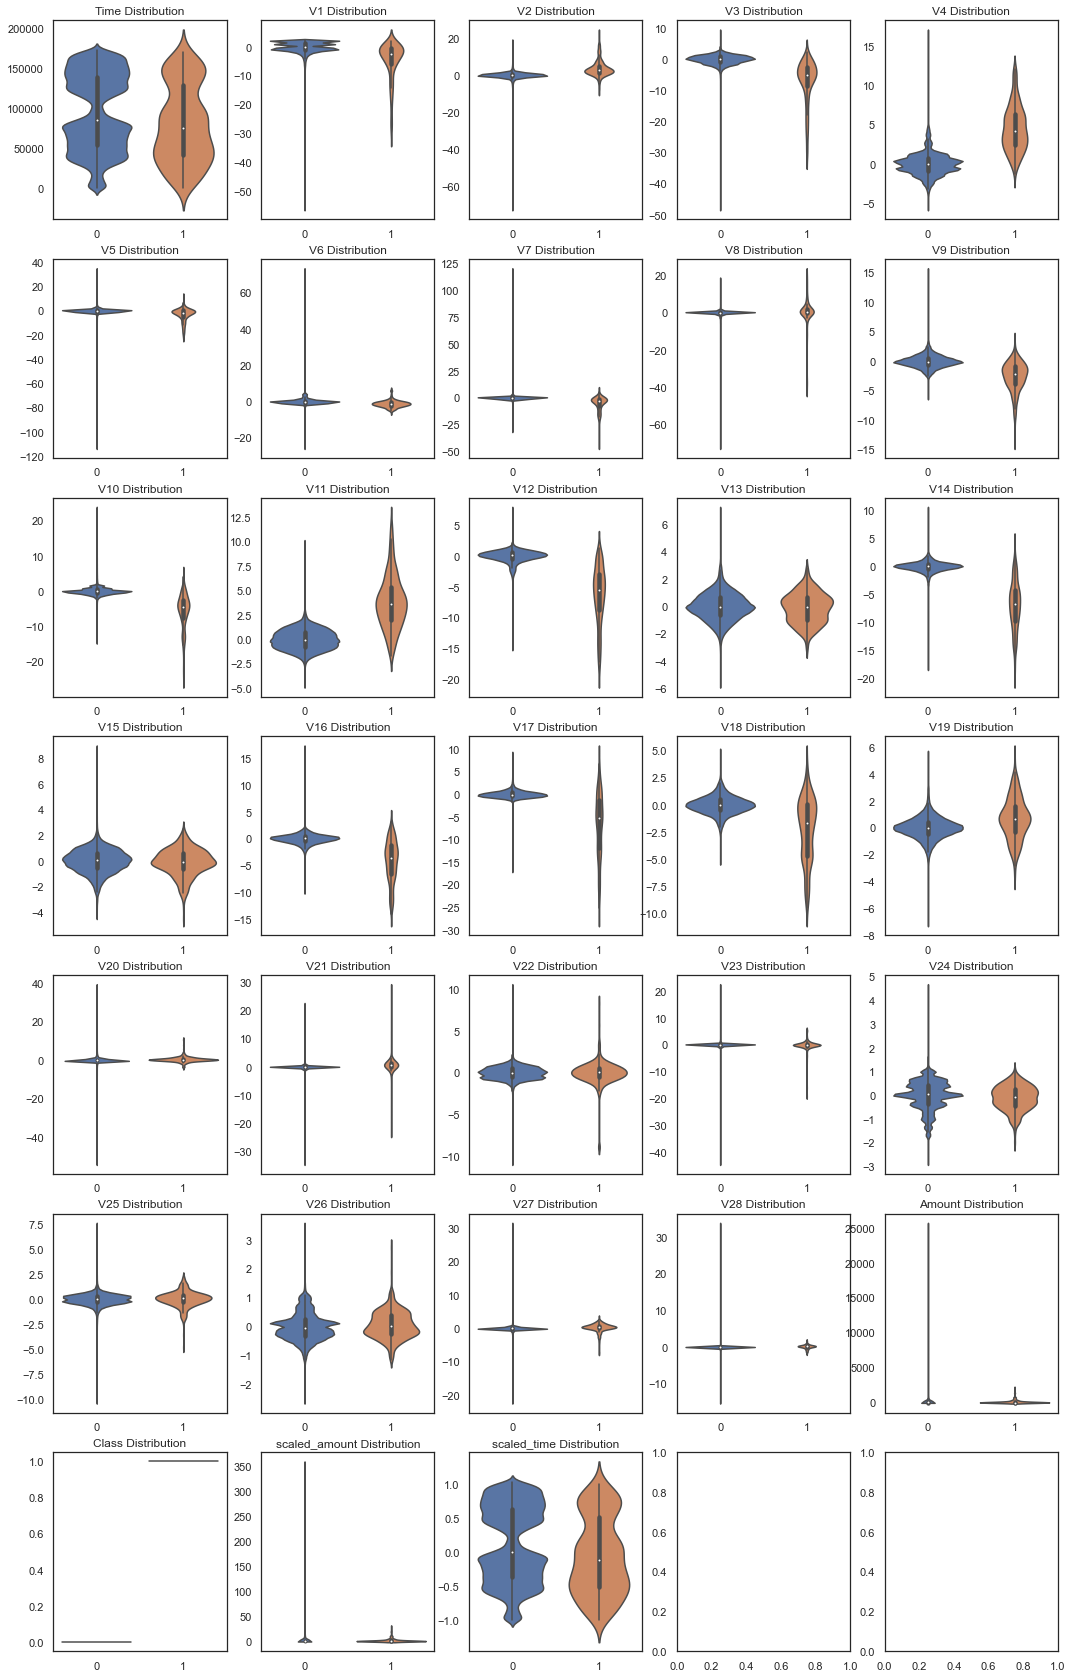

In [21]:
fig, ax = plt.subplots(7,5, figsize=(18,30))
i=0 # intilizing counter
for  ax,( i, col) in zip(ax.flat, enumerate(data.columns)):
#     print(ax, i,col)
    sns.violinplot(x= 'Class', y=col, data=data, ax=ax)
#     ax.set_xlim([min[data[col]], max[data[col]]])
    ax.set_title('{} Distribution'.format(col))
    ax.set_xlabel ('')
    ax.set_ylabel('')

From the box plots above we find some interesting insights. Just as in our correlaltion above, the negative correlated features(V3, V7, V10,V14, etc..) and positively (V2, V4, V11) seem to show the a statistal difference in the fraud and non fraud transactions, we could also confirm using ttests and statistal analysis in future work.  

In [ ]:
# looking at the most positively correlated parameters
int_param = da

In [22]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274,-0.994983
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825,-0.994983
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721,-0.994972
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291,-0.994972
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579,-0.994960


In [56]:
corr_with = data.drop('scaled_amount', axis=1).drop('scaled_time', axis=1).drop('Class', axis =1).corrwith(data.Class)
pos_corr = corr_with[corr_with >0].sort_values(ascending=False)

int_parameters = pos_corr.head(6).index.values


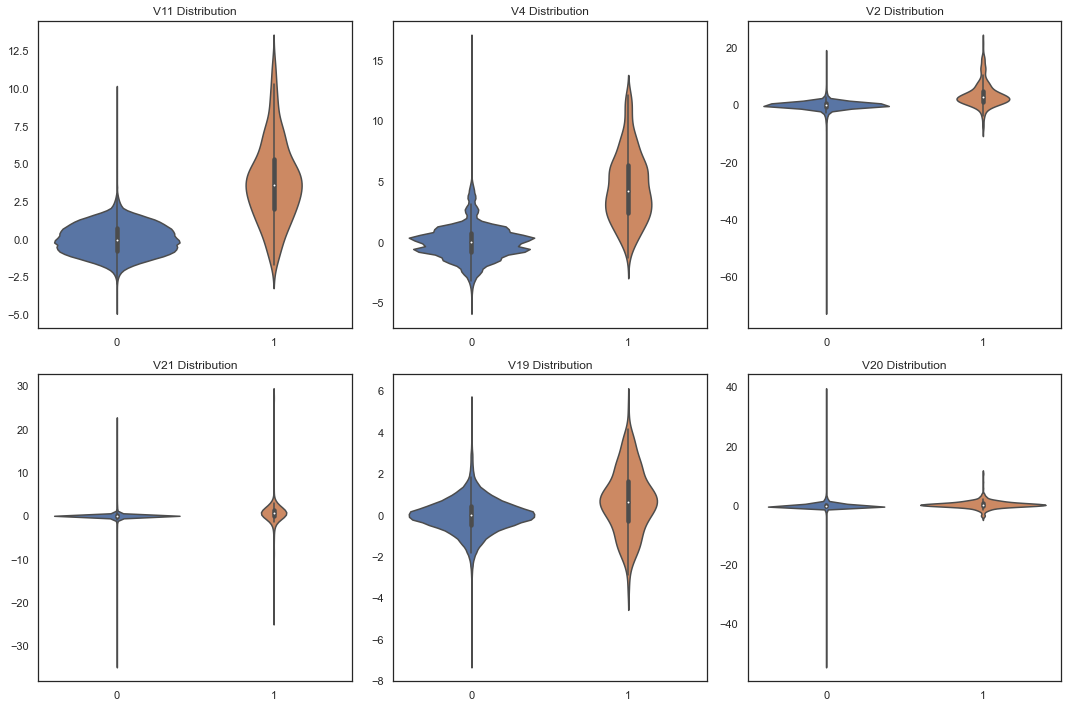

In [58]:
fig, ax = plt.subplots((len(int_parameters)//3) ,3, figsize=(15,10))
for  ax,( i, col) in zip(ax.flat, enumerate(data[int_parameters].columns)):
#     print(ax, i,col)
    sns.violinplot(x= 'Class', y=col, data=data, ax=ax)
#     ax.set_xlim([min[data[col]], max[data[col]]])
    ax.set_title('{} Distribution'.format(col))
    ax.set_xlabel ('')
    ax.set_ylabel('')
fig.tight_layout()
fig.saveimg('positive_corr.png')
fig.savefig('images/positive_corr.png')

In [60]:
fig.savefig('images/positive_corr.png')

We see some intersting insights here. The parameters are sorted by the correlation with fraud, we observer large discrepnsies in averages and modes for the top 3 parameters however does not seem as obvious from the others. We can run T-Tests to see if there is any statistal difference between the cases for these parameters. 